This Jupyter notebook contains the code to perform simulations for the mini project 'Addressing mode collapse in GANs' at C6.5 Theories of Deep Learning at the Mathematical Institute of the University of Oxford. This project was done in fulfillment of the broadnening requirements for the D.Phil.

In [13]:
import math
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
from typing import List
from IPython.display import display, clear_output

We will use the Scikit-learn Moons toy dataset to show mode collapse in a very simple GAN. For that we define a function that can output random samples from this dataset. 

In [460]:
def generate_from_moons(batch_size):
    Xmoon, ymoon = make_moons(batch_size, noise=0,random_state=np.random.randint(0,1000,1)[0])
    labels = [1]*batch_size
    data = [Xmoon[i,:] for i in range(Xmoon.shape[0])]
    return labels, data

In the cell below, we create the generator. 

In [632]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2,8),
            nn.ReLU(inplace=True),
            nn.Linear(8,4),
            nn.ReLU(inplace=True),
            nn.Linear(4, 2),
        )
    
    def forward(self, z):
        return self.model(z)

Next, we create the discriminator. 

In [573]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 8),
            nn.Tanh(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

The following function will allow us to extract easily plottable numpy arrays from a list containing data.

In [441]:
def make_scatter(data,batch_size):
    xShape = len(data)
    storeData = np.zeros((xShape,2))
    for i in range(xShape):
        storeData[i,:] = data[i]    
    return storeData

The following function is used to initialize the weights of the GAN. 

In [614]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.01)

The following code performs iterations over the different epochs. The training part of the code is based on the tutorial https://towardsdatascience.com/build-a-super-simple-gan-in-pytorch-54ba349920e4. We use Stochastic Gradient Descent and choose a small learning rate.

In [635]:
def train(max_int: int = 128, batch_size: int = 32, training_steps: int = 200000):
    refX =make_scatter(make_moons(1000, noise=0,random_state=np.random.randint(0,1000,1)[0])[0],1000)
    input_length = 2
    # Models
    generator = Generator()
    discriminator = Discriminator()
    
    generator.apply(init_weights)
    discriminator.apply(init_weights)
    
    # Optimizers
    generator_optimizer = torch.optim.SGD(generator.parameters(), lr=0.0005)
    discriminator_optimizer = torch.optim.SGD(discriminator.parameters(), lr=0.0005)

    #Define cross entropy loss
    loss = nn.BCELoss()
    
    #Set seed
    np.random.seed(42)
    for i in range(training_steps):
        generator_optimizer.zero_grad()
        
        #create latent variables
        noise = torch.normal(0, 1, size=(batch_size, input_length)).float()
        
        #create generator predictions
        generated_data = generator(noise)
        
        #sample from true data
        true_labels, true_data = generate_from_moons(batch_size=batch_size)  
        true_labels = torch.tensor(true_labels).float()
        true_data = torch.tensor(true_data).float()
        
        #For showing animation in the output of the notebook
        if(i%250==0):
            pNoise = torch.normal(0, 1, size=(500, input_length)).float() #To visualize
            tD = generator(pNoise).data.numpy() #convert into plottable form
            tD = make_scatter(tD,500)
            clear_output(wait=True) #to refresh output in Jupyter notebook
            fileName = 'GAN'+str(i) 
            plt.scatter(tD[:,0],tD[:,1],c='b',s=5,marker='o',alpha=0.5)
            plt.scatter(refX[:,0],refX[:,1],s=0.5,c='r') #output true data
            plt.title('Epochs: %d'%i)
            plt.savefig(fileName,dpi=750)
            plt.show()

        # Train generator
        generator_discriminator_out = discriminator(generated_data)
        true_labels = true_labels.unsqueeze(1)
        generator_loss = loss(generator_discriminator_out.float(), true_labels.float())
        generator_loss.backward()
        generator_optimizer.step()

        # Train discriminator 
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out.float(), true_labels.float())
        generator_discriminator_out = discriminator(generated_data.detach())
        tz = torch.zeros(batch_size).unsqueeze(1)
        generator_discriminator_loss = loss(generator_discriminator_out, tz)
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()

The command below performs the training. If the plot statements in the code are enabled, the cell below will show an animation of the predictions made by the generator. Note that the distribution of the outputs is the same after a while, we keep going to make sure that there is convergence. 

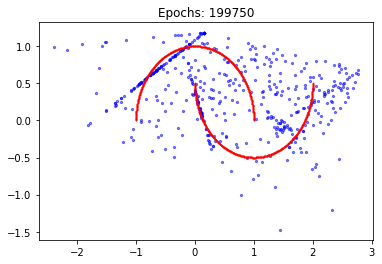

In [636]:
train()